# Modeling Antibiotic Responce Through Datamining in the MIMICIII Dataset
### Group 2: Garrett Eickelberg, Kishore Anekalla, Yikuan Li

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#reserach question:
-Can we predict the 5/7 day ab course by 48 hours after culture/ab start for icu patients?

#cohort criteria:
- YES- only adult patients (over 18 yo)  (~n= 38,000 age >18)
- with sterile culture 
- and ab start within the same 24 hours time window (bulk will be in first 24 hours but possibly not). 


Three subsets:
– Started on antibiotics, after 48hrs, negculture, discontinue	: neg/stop
- 48hrs, negculture, but continue full course 7, 10, or 14 days: neg/continue
– Positive culture, continue full course.Predict whether kept on antibiotics:

    pos/continue
    
	Infected with positive culture
    
	Infected with negative culture (ie a false positive)
    
    
#components: data cleaning, model building

In [1806]:
#code used to ping the postgres mimic server. 

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password:········
time: 2.49 s


# importing prescription table annotated with RXCUI and ATC codes to id AB

In [114]:

ABrx = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')
#see 01-prescription.ipynb or 02-cohort_generation.ipynb for full details of this prescription table.

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Persisting input arguments took 1.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


In [152]:
ABrx

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,gsn,ndc,prod_strength,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,route,rxcui,Antibiotics
16,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,NaN,...,053190,6.791900e+10,500mg Vial,350,mg,0.7,VIAL,IV,404652,True
28,1867722,24922,165593,268898.0,2165-01-02,2165-01-08,MAIN,Ceftazidime,NaN,NaN,...,015538,1.730412e+08,1GM FROZ. BAG,1,gm,1,BAG,IV,NaN,False
75,2804000,24942,178112,278729.0,2159-11-08,2159-11-10,MAIN,Vancomycin HCl,NaN,NaN,...,043952,3.383552e+08,1g Frozen Bag,1000,mg,1,BAG,IV,1807508,True
98,993369,24955,154989,NaN,2142-09-21,2142-10-08,MAIN,Sulfameth/Trimethoprim SS,Sulfameth/Trimethoprim SS,Sulfameth/Trimethoprim SS,...,009395,9.300880e+07,1 TAB,1,TAB,1,TAB,PO,198334,True
117,2338288,24968,127995,NaN,2190-07-14,2190-07-15,MAIN,NEO*IV*Gentamicin,NaN,NaN,...,009298,6.410394e+08,10mg/mL-2mL,5,mg,0.5,ml,VT,NaN,False
139,2338293,24968,120350,219670.0,2190-08-01,2190-08-02,MAIN,Vancomycin HCl,NaN,NaN,...,043952,3.383552e+08,1g Frozen Bag,1000,mg,1,BAG,IV,1807508,True
141,2338290,24968,120350,219670.0,2190-08-01,2190-08-02,MAIN,Cefepime,NaN,NaN,...,027470,5.147901e+10,2g Vial,2,gm,10,ml,IV,NaN,False
180,1004062,24776,139951,295185.0,2154-11-15,2154-11-19,MAIN,Gentamicin Sulfate,NaN,NaN,...,009299,5.486841e+10,40mg/mL-2mL,450,mg,11.25,mL,IV,NaN,False
195,1004065,24776,139951,295185.0,2154-11-19,2154-11-18,MAIN,Vancomycin,NaN,NaN,...,043952,3.383552e+08,1g Frozen Bag,1000,mg,1,BAG,IV,1807508,True
249,1168588,24808,161457,NaN,2149-10-24,2149-10-28,MAIN,Vancomycin HCl,NaN,NaN,...,009329,2.735501e+06,1GM FROZ. BAG,1000,mg,1,BAG,IV,NaN,False


time: 584 ms


# making a clean list of AB labels from ATC and D_items

Problem:

    MIMICIII doesn't have a comprehensive list of antibiotics annotated.


solution strategy:

1)make a list of antibiotic names from two different sources and combine them:

    d_item list annotated with Antibiotic column
    
    prescription table annotated with ATC antibiotic info
    
2)use the list of antibiotics to find all the item id's in d_item list. 
    
     

In [31]:
#d_item_microbio_list generation
#the caviot list is due to antivirals and antibacterials being present in the antibiotic list
d_items_sql = query_schema + """
select itemid, label, dbsource, linksto, category, unitname, param_type, conceptid 
from mimiciii.d_items
WHERE (category = 'Antibiotics' or category = 'ANTIBACTERIUM') and lower(label) not like '%fung%' 
and lower(label) not in ('voriconazole','valgancyclovir','chloroquine','tamiflu','mefloquine','foscarnet','fluconazole','vorconazole','quinine',
'ribavirin','gancyclovir','chloroquine','atovaquone','ambisome', 'acyclovir', 'Acyclovir')
order by category, label desc;
"""

d_items_df=pd.read_sql_query(d_items_sql,conn)
d_item_microbio_list=d_items_df['label'].unique().tolist()
d_item_microbio_list=[str(x).lower() for x in d_item_microbio_list]


In [2002]:
d_items_sql

"SET search_path to mimiciii;\nselect itemid, label, dbsource, linksto, category, unitname, param_type, conceptid \nfrom mimiciii.d_items\nWHERE (category = 'Antibiotics' or category = 'ANTIBACTERIUM') and lower(label) not like '%fung%' \nand lower(label) not in ('voriconazole','valgancyclovir','chloroquine','tamiflu','mefloquine','foscarnet','fluconazole','vorconazole','quinine',\n'ribavirin','gancyclovir','chloroquine','atovaquone','ambisome', 'acyclovir', 'Acyclovir')\norder by category, label desc;\n"

time: 65.8 ms


In [17]:
#function to parse out ABrx_Drug_list
#uses regular esxpressions and rule based parsing

i=0
replace_list= [
    'sodium','hcl','potassium','sulfate','potassium','monohydrate', 
    'oral susp.','ophthalmic oint', 'desensitization', r'% solution',
    'hippurate','suspension','ointment','phosphate', 'soln', 'solution',
    'ophth.','ophth.','*nf*']
    
@memory.cache
def parsingfxn(element):
    element = r'%s'%(element)
    element = re.sub(r'\b\w{1,3}\b', r"", element)
    element= element.strip(r" ")
    for j in replace_list:
        element= element.replace(j, r'')   
    element= element.strip(r" ")
    if r"**" == str(element)[0:2]:
        element = str(element)[2:]
    element = element.split(r".%")[0]
    element = element.split(r". %")[0]
    element = element.split(r"ophth*")[0]
    element = element.split(r"-")[0]
    element = element.split(r"(")[0]
    element = element.split(' ',1)[0]
    return(element)    

In [18]:
ABrx_Drug_list3 =[parsingfxn(x) for x in ABrx_Drug_list]
ABrx_Drug_list3= list(set(ABrx_Drug_list3))
ABrx_Drug_list3.remove('')

In [33]:
#final consensus list coding
Combo_AB_name_list=[]
Combo_AB_name_list = ABrx_Drug_list3 + d_item_microbio_list
Combo_AB_name_list= list(set(Combo_AB_name_list))

#cleaning
#Combo_AB_name_list.remove('none')
Combo_AB_name_list.remove('poly')
Combo_AB_name_list.remove('eryth')
Combo_AB_name_list.remove('gent')
Combo_AB_name_list.remove('sulfa')
Combo_AB_name_list.remove('genta')
Combo_AB_name_list.remove('bact')

print(len(Combo_AB_name_list))
##95

95


['sulfamet',
 'penicillin',
 'streptomycin',
 'neomycin',
 'oxacillin',
 'ceftazidime',
 'cefepime',
 'imipenem',
 'sulfameth/trimet']

now we have 95 items in my list that are antibiotics based on normal expression and rule based parsing of the ATC prescription list interfaced with prescription tab and labels of microbio linked ab in d_items. now to merge with kishore's list of ab.

In [34]:
kishore_list= ['amikacin',
 'amoxicillin','ampicillin','avelox','azithromycin','aztreonam','bacitracin','bactrim','benzathine',
 'cefazolin','cefepime','cefixime','cefotaxime','cefotetan', 'cefpodo',
 'cefpodoxime', 'ceftaroline',
 'ceftazidime','ceftriaxone','cephalexin','chloramphenicol','cilastatin',
 'ciprofloxacin','clarithromycin','clavulanic',
 'clindamycin','colistimethate','colistin','daptomycin',
 'demeclocycline','desensitization','dexamethasone','dicloxacillin',
 'doxycycline','ertapenem','erythromycin','ethylsuccinate','flagyl','fortified','fosfomycin','furosemide',
 'gentamic','gentamicin','gramicidin','hippurate',
 'imipenem','levofloxacin','linezolid','macrobid',
 'macrocrystal','macrodantin','meropenem','methenamine',
 'metronidazole','moxifloxacin','nafcillin','neomycin',
 'nffloxin','nitrofurantoin','ocuflox','ofloxacin','ophthalmic','oxacillin',
 'penicillin','piperacillin','polymyxin','polysporin',
 'proxetil','streptomycin','sulbactam',
 'sulfadiazine','sulfame','sulfamet','sulfameth','sulfamethoxazole',
 'tazobactam','tigecycline','tobramycin','trimeth',
 'trimetho','trimethopri','trimethoprim',
 'tromethamine','unasyn','vancomycin','vigamox','zithromax','zosyn']

In [35]:
consensus_kishore_mylist = []
consensus_kishore_mylist= kishore_list + Combo_AB_name_list
consensus_kishore_mylist= list(set(consensus_kishore_mylist))
len(consensus_kishore_mylist) 
#95->120 after removing antivirals/fungals on march 11. was at 135 before removing all erronious ab

120

next task: 
use the list of antibiotics and regular expressions to find all antibiotic item id's in d_items corresponding to the antibiotics in our list.

In [36]:
#algorithm to loop through our consensus ab list of labels and 
#input them into a like command to find associated d_item id's

abid_test_list=[]
for element in consensus_kishore_mylist:

    d_items_sql2 = query_schema + """
    select itemid, label, dbsource, linksto, category, unitname, param_type, conceptid 
    from mimiciii.d_items
    WHERE lower(label) like '%{}%'
    order by itemid desc;
    """.format(element.strip())

    d_items_df2=pd.read_sql_query(d_items_sql2,conn)
    abid_test_list= abid_test_list +d_items_df2['itemid'].unique().tolist()
    abid_test_list= list(set(abid_test_list))

#using getting all d_item info from ab list    
d_items_sql3 = query_schema + """
    select itemid, label, dbsource, linksto, category, unitname, param_type, conceptid 
    from mimiciii.d_items
    WHERE itemid in {}
    order by itemid desc;
    """.format(tuple(abid_test_list))
    
d_items_df3=pd.read_sql_query(d_items_sql3,conn)    

len(abid_test_list) #171 after removing antivirals/fungals and non-ab from list 3/11/18.
print(len(d_items_df3['itemid'].unique())) #171 as well

171


In [39]:
#QC
#making a list of item id's that were recruited in query, but are not antibiotics
#these will be removed from the antibiotic list going forward
@memory.cache
def d_item_list_generation_fxn(ablist_input):
    morphine_list= [1813,5613,7424,30153,30126,225154]
    lasix_list=[3439,228340,221794]
    magnesium_list = [6133, 30027, 222011, 227523, 227524]

    misc_list= [42565, 30024, 42041 ]
    #examples:
    #Tromethamine  - NOT AN AB -42565
    #ferrous sulfate - NOT AN AB-30024
    #barium sulfate- NOT AN AB- 42041

    all_rm_list= morphine_list + lasix_list + magnesium_list + misc_list
    
    FINAL_DITEM_ABLIST= list(ablist_input) 
    FINAL_DITEM_ABLIST = [x for x in FINAL_DITEM_ABLIST if x not in all_rm_list]
    return(FINAL_DITEM_ABLIST)

FINAL_DITEM_ABLIST= d_item_list_generation_fxn(d_items_df3['itemid'].unique())


167

# generating EVENT patient list
goal: now that we have ab list, need to generate list of all patients who have ever been prescribed ab

strategy: use series of sql like joins

In [800]:
#on 4-17-18 made this outdated by generating a much more comprehensive patient info dataframe: ptinfo_ICUsterile_16_pt

#on 4/20 found a bug where pt 85 is not in ptinfo_ICUsterile_16. saving and regenerating
#update: was fixed after rerunnign the code...
#pd.DataFrame(ptinfo_ICUsterile_16).to_csv('ptinfo_ICUsterile_16_04-20-18.csv')

time: 861 µs


In [578]:
#generating inputevents table 

###CV patients
####chart events
chartevents_sql = query_schema + """
select * from chartevents
WHERE itemid in {}""".format(tuple(FINAL_DITEM_ABLIST))

chartevents_df=pd.read_sql_query(chartevents_sql,conn)

####inputevents_cv
inputevents_cv_sql = query_schema + """
select * from inputevents_cv
WHERE itemid in {}""".format(tuple(FINAL_DITEM_ABLIST))

inputevents_cv_df=pd.read_sql_query(inputevents_cv_sql,conn)

####inputevents_mv
inputevents_mv_sql = query_schema + """
select * from mimiciii.inputevents_mv mv
left join (SELECT di.itemid, di.label from mimiciii.d_items di) di on di.itemid= mv.itemid
WHERE mv.itemid in {}""".format(tuple(FINAL_DITEM_ABLIST))


inputevents_mv_df=pd.read_sql_query(inputevents_mv_sql,conn) 

DatabaseError: Execution failed on sql 'SET search_path to mimiciii;
select * from inputevents_mv mv
left join (SELECT itemid, label from mimiciii.d_items di) di on mv.itemid= di.itemid
WHERE itemid in (227691, 227455, 227454, 227453, 227452, 227451, 227450, 227449, 227448, 227447, 226069, 226068, 226067, 226066, 226065, 226064, 225902, 225900, 225899, 225898, 225895, 225893, 225892, 225890, 225889, 225888, 225886, 225884, 225883, 225881, 225879, 225877, 225876, 225875, 225868, 225866, 225865, 225863, 225862, 225860, 225859, 225855, 225853, 225851, 225850, 225847, 225845, 225843, 225842, 225840, 225798, 225697, 225688, 225662, 90031, 90030, 90029, 90028, 90027, 90026, 90025, 90024, 90023, 90022, 90021, 90020, 90019, 90018, 90017, 90016, 90015, 90014, 90013, 90012, 90011, 90010, 90009, 90008, 90007, 90006, 90005, 90004, 90003, 90002, 80182, 45647, 43924, 41609, 8273, 8070, 8019, 7924, 7546, 7500, 7362, 7349, 7223, 6975, 6610, 6536, 6381, 6201, 6098, 6046, 5887, 5770, 5658, 5612, 5528, 5527, 5523, 5380, 5356, 5273, 5204, 5141, 5115, 5063, 5062, 5060, 5025, 4972, 4958, 4952, 4950, 4926, 4812, 4792, 4762, 4740, 4735, 4732, 4715, 4693, 4660, 4590, 4587, 4561, 4557, 4538, 4511, 4497, 4448, 4426, 4417, 4415, 4364, 4256, 4223, 4220, 4215, 3828, 3827, 3757, 3756, 3679, 3554, 3445, 3412, 3369, 3303, 856, 855, 854, 847, 846, 845)': column reference "itemid" is ambiguous
LINE 4: WHERE itemid in (227691, 227455, 227454, 227453, 227452, 227...
              ^


time: 32.6 s


In [600]:
inputevents_mv_sql = query_schema + """
select * from mimiciii.inputevents_mv mv
left join (SELECT di.itemid, di.label from mimiciii.d_items di) di on di.itemid= mv.itemid
WHERE mv.itemid in {}""".format(tuple(FINAL_DITEM_ABLIST))


inputevents_mv_df=pd.read_sql_query(inputevents_mv_sql,conn) 
inputevents_mv_df= inputevents_mv_df.ix[:,~inputevents_mv_df.columns.duplicated()] #removing the extra itemid

time: 19.3 s


# generating patient culture/icu/hospital info


In [1380]:
#retrieving all patients with sterile culture

##changed on 4/16/18 to include all hadm_id
sterile_pt_sql = query_schema + """
SELECT row_id, subject_id, hadm_id, chartdate, charttime, spec_itemid, spec_type_desc, org_name FROM mimiciii.microbiologyevents
WHERE NOT lower(spec_type_desc) = 'fluid received in blood culture bottles' AND
NOT lower(spec_type_desc) = 'blood bag fluid'
AND (lower(spec_type_desc) LIKE '%blood%' 
OR lower(spec_type_desc) LIKE '%joint%' 
OR lower(spec_type_desc) LIKE '%urine%' 
OR lower(spec_type_desc) LIKE  '%csf%'
OR lower(spec_type_desc) LIKE '%spinal%'
OR lower(spec_type_desc) LIKE '%pleural%'
OR lower(spec_type_desc) LIKE '%peritoneal%')
group by subject_id, row_id
ORDER BY count(subject_id) DESC
"""

sterile_pt_df=pd.read_sql_query(sterile_pt_sql,conn) #33900 patients with sterile culture


time: 29.4 s


In [214]:
#retrieving pt_age, icustay_ids, dbsource (for icustay or overall)
#initializing
#pt_age_icustay_df = pd.DataFrame()
pt_age_df = pd.DataFrame()
pt_over16 = pd.DataFrame()


pt_age_sql = query_schema + """
SELECT
      p.subject_id, p.dob, p.gender
      , MIN (a.admittime) AS first_admittime
      , MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM mimiciii.patients p
  
  INNER JOIN mimiciii.admissions a
  ON p.subject_id = a.subject_id
  GROUP BY p.subject_id, p.dob, p.gender
  ORDER BY p.subject_id

"""

pt_age_df = pd.read_sql_query(pt_age_sql,conn) #46520 patients total, no ab, culture or age restrict
pt_over16 = pt_age_df.loc[pt_age_df.loc[:,'first_admit_age']>16,:] #38637
#pt_over16 = pt_over16.rename(index=str, columns={"admittime":'hosp_admit','dischtime':'hosp_disch'})

time: 929 ms


In [210]:
#a more detailed patient/admission/age data query

pt_age_admin_sql = query_schema + """
select p.subject_id, c.hadm_id, c.admittime, c.dischtime, c.admission_location, c.admission_type, p.first_admit_age, p.dob, p.gender from mimiciii.admissions c
join (SELECT
      p.subject_id, p.dob, p.gender, MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM mimiciii.patients p
  INNER JOIN mimiciii.admissions a
  ON p.subject_id = a.subject_id
  GROUP BY p.subject_id, p.dob, p.gender
  ORDER BY p.subject_id) p on c.subject_id = p.subject_id

"""
pt_age_admin_df = pd.read_sql_query(pt_age_admin_sql,conn) #38637
pt_age_admin_16_df= pt_age_admin_df.loc[pt_age_admin_df.loc[:,'first_admit_age']>16,:]
pt_age_admin_16_df = pt_age_admin_16_df.rename(index=str, columns={"admittime":'hosp_admit','dischtime':'hosp_disch'})

pt_source_sql = query_schema + """
SELECT subject_id, icustay_id, hadm_id, dbsource, intime, outtime, los, FIRST_WARDID, LAST_WARDID from mimiciii.icustays
"""
pt_source_df =pd.read_sql_query(pt_source_sql,conn) #46520 patients total, no ab, culture or age restrict
pt_source_df = pt_source_df.rename(index=str, columns={"intime":'ICU_admit','outtime':'ICU_disch'})

#merging icu info with patient admiin info- has all icustay id's with patient and admission info.
pt_icu_hosp_db_16 =pd.merge(pt_age_admin_16_df,pt_source_df.drop(['subject_id'], axis=1), left_on= 'hadm_id', right_on='hadm_id', how = 'right')
# len(pt_source_df) #61532
# len(pt_age_admin_16_df)#50857
# len(pt_icu_hosp_db_16) #61532



time: 12.2 s


In [237]:
len(ABrx_ntnull['icustay_id'].unique())

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
pt_ab_age_df['first_admit_age'].sort_values(ascending=True).plot.hist(100)

33956

time: 6.55 ms


### - mergeing sterile_pt_df with pt_icu_hosp_db_16
    filtering and merging patient/hospital/icu admin data for pt>16 yo, with all sterile culture pt.
    final df- ptinfo_ICUsterile_16:
    is all the hospital, icu admission, and patient data for patients >=16yo, 
    with a sterile culture associated with hadm_id that occured during icu timewindow



In [791]:
#1merge sterile_pt_df with pt_icu_hosp_db_16

sterile_all_pt_info= None
sterile_all_pt_info = pd.merge(pt_icu_hosp_db_16, sterile_pt_df.drop(['subject_id'], axis=1), left_on= 'hadm_id', right_on='hadm_id', how = 'inner')
#filtering and merging patient/hospital/icu admin data for pt>16 yo, with all sterile culture pt.

sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'charttime'] = sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'chartdate']
#making all sterile culture charttime null rows = to chartdate. 

len(sterile_all_pt_info) #438662 rows
len(sterile_all_pt_info['hadm_id'].unique()) #41655 
len(sterile_all_pt_info['icustay_id'].unique())# 45126

#this line just annotates the sterile cultures and returns True if it's within the icu time window.
#this is also accounted for later in my filtering with the '('ab and sterile culture within 24 hour criteria'
##sterile_all_pt_info['sterile_dur_icu']= (sterile_all_pt_info['ICU_disch'] >= sterile_all_pt_info['charttime']) &(sterile_all_pt_info['charttime']>=sterile_all_pt_info['ICU_admit'])

###removed below line because we want to include sterile cultures outside of ICU. 
#sterile_all_pt_info_icu= sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'sterile_dur_icu']==True,:]

###master#### 
#this is all the hospital, icu admission, and patient data for patients >=16yo, 
#with a sterile culture associated with hadm_id that occured during icu timewindow.
#note due to removing icu restriction, the ptinfo_ICUsterile_16 and sterile_all_pt_info are the same  because i filtered on 16yo earlier.
#i kept it this way for ease of naming convention. may clean up at a later date.
ptinfo_ICUsterile_16=0
ptinfo_ICUsterile_16= sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'first_admit_age']>=16,:] #changed from sterile_all_pt_info_icu
###master####
ptinfo_ICUsterile_16=ptinfo_ICUsterile_16.rename(index=str, columns={'charttime':'culture_charttime'})


45126

time: 560 ms


In [797]:
# ###unfortunately this isn't super helpful as the first sterile culture isn't important, the one taken within 24 hour of ab is. 



#1.6 first sterile culture annotation by icustay_id
# # adding hadm_date_range, first sterile date (associated with hadm_id), and number of cultures per hadm_id to sterile culture db

# ##on 4/22/18- I'm gunna try to  adjust this to have 24hrab_culture date vs first_sterile_date

# from numpy import nan
# @memory.cache
# def sterile_culture_annotation(sterileculture_db):
#     sterileculture_db['culture_hadm_date_rng'] = nan
#     sterileculture_db['first_sterile_date'] = nan
#     sterileculture_db['culture_count'] = nan
#     sterileculture_db['culture_hadm_date_rng'] = pd.to_datetime(sterileculture_db.groupby('icustay_id')['culture_charttime'].transform('max')) - pd.to_datetime(sterileculture_db.groupby('icustay_id')['culture_charttime'].transform('min'))        
#     sterileculture_db['first_sterile_date'] = sterileculture_db.groupby('icustay_id')['culture_charttime'].transform(lambda x: pd.to_datetime(min(x)))
#     sterileculture_db['culture_count'] = sterileculture_db.groupby('icustay_id')['culture_charttime'].transform(lambda x: len(x))    
#     return(sterileculture_db)

# ptinfo_ICUsterile_16= sterile_culture_annotation(ptinfo_ICUsterile_16)
# #sterile_culture_annotation(sterile_pt_df3.sort_values('subject_id'))

time: 16.7 s


In [798]:
# FIXED
#debugging why pt 85 is excluded from ptinfo_ICUsterile_16_pt

# ptinfo_ICUsterile_16.loc[ptinfo_ICUsterile_16.loc[:,'subject_id']==85,:] 
# #pt not in this

,subject_id,hadm_id,hosp_admit,hosp_disch,admission_location,admission_type,first_admit_age,dob,gender,icustay_id,...,last_wardid,row_id,chartdate,culture_charttime,spec_itemid,spec_type_desc,sterile_dur_icu,culture_hadm_date_rng,first_sterile_date,culture_count
400,85.0,112077,2167-07-25 18:49:00,2167-07-30 15:24:00,CLINIC REFERRAL/PREMATURE,EMERGENCY,71.45,2090-09-18,M,291697,...,23,600,2167-07-25,2167-07-25 17:30:00,70012,BLOOD CULTURE,False,2 days 19:13:00,2167-07-25 16:50:00,4
401,85.0,112077,2167-07-25 18:49:00,2167-07-30 15:24:00,CLINIC REFERRAL/PREMATURE,EMERGENCY,71.45,2090-09-18,M,291697,...,23,602,2167-07-28,2167-07-28 12:03:00,70081,URINE,False,2 days 19:13:00,2167-07-25 16:50:00,4
402,85.0,112077,2167-07-25 18:49:00,2167-07-30 15:24:00,CLINIC REFERRAL/PREMATURE,EMERGENCY,71.45,2090-09-18,M,291697,...,23,598,2167-07-25,2167-07-25 16:50:00,70012,BLOOD CULTURE,False,2 days 19:13:00,2167-07-25 16:50:00,4
403,85.0,112077,2167-07-25 18:49:00,2167-07-30 15:24:00,CLINIC REFERRAL/PREMATURE,EMERGENCY,71.45,2090-09-18,M,291697,...,23,599,2167-07-25,2167-07-25 17:20:00,70012,BLOOD CULTURE,False,2 days 19:13:00,2167-07-25 16:50:00,4


time: 54 ms


# accounting for all sterile cultures taken within 48 hours of the first ab. 
4/22/18

In [ ]:
#big question to answer, all sterile cultures within 48 hours of what? i am going to set timeframe for each patient: 
#look at all cultures between the first SC within 24 hour of ab and up to 48 hours after first ab dose in ICU.
#this means the max i will cover is 72 hours. 

In [1350]:
list(ABrx_16sterile_ntnul_absquash)
sc_columns=['subject_id', 'icustay_id','hadm_id', 'culture_charttime',
            'spec_itemid', 'spec_type_desc', 'sterile_dur_icu', 'culture_hadm_date_rng',
            'culture_count', 'pt_ab_db','ab_icu_date', 'ab_icu_end', 'ab_culture_delta', 'ab_icu_date','ab_icu_end', 't_0']

ABrx_16sterile_ntnul_absquash[sc_columns]
#list(ABrx_16sterile_ntnul_absquash)

,subject_id,icustay_id,hadm_id,culture_charttime,spec_itemid,spec_type_desc,sterile_dur_icu,culture_hadm_date_rng,culture_count,pt_ab_db,ab_icu_date,ab_icu_end,ab_culture_delta,ab_icu_date,ab_icu_end,t_0
0,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2182-12-10,2182-12-10,10 days 11:41:00,2182-12-10,2182-12-10,2182-11-29
1,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2182-11-29,2182-12-24,-1 days +11:41:00,2182-11-29,2182-12-24,2182-11-29
2,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2182-11-17,2182-11-20,-13 days +11:41:00,2182-11-17,2182-11-20,2182-11-29
3,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2182-11-17,2182-11-29,-13 days +11:41:00,2182-11-17,2182-11-29,2182-11-29
4,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2183-01-12,2183-01-15,43 days 11:41:00,2183-01-12,2183-01-15,2182-11-29
5,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2182-11-12,2182-11-15,-18 days +11:41:00,2182-11-12,2182-11-15,2182-11-29
6,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2182-11-12,2182-11-17,-18 days +11:41:00,2182-11-12,2182-11-17,2182-11-29
7,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2182-11-12,2182-11-26,-18 days +11:41:00,2182-11-12,2182-11-26,2182-11-29
8,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2182-11-15,2182-11-15,-15 days +11:41:00,2182-11-15,2182-11-15,2182-11-29
9,24915,267059,194424,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,85,cv_ab,2183-01-03,2183-01-03,34 days 11:41:00,2183-01-03,2183-01-03,2182-11-29


time: 69.7 ms


In [ ]:
# #taken from my building patient list from PRESCRIPTIONS

# lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul_absquash['ab_icu_date']) - pd.to_datetime(
#     ABrx_16sterile_ntnul_absquash['culture_charttime'])) <='24:00:00'


# ABrx_16sterile_ntnul_absquash['ab_culture_delta'] = pd.to_datetime(ABrx_16sterile_ntnul_absquash['ab_icu_date']) - pd.to_datetime(ABrx_16sterile_ntnul_absquash['culture_charttime'])

# ABrx_ab24hrdelta= ABrx_16sterile_ntnul_absquash.loc[lessthan24hr]

# ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['ab_icu_date'].transform(lambda x: min(x))

# ABrx_16sterile_ptAB24startdate= ABrx_ab24hrdelta[['icustay_id','t_0']].drop_duplicates('icustay_id')

# ABrx_16sterile_ptAB24enddate= ABrx_ab24hrdelta[
#     ABrx_ab24hrdelta['ab_icu_date']==ABrx_ab24hrdelta[
#         't_0']].sort_values(
#             ['subject_id','icustay_id','enddate'], ascending=[True,True,False]).drop_duplicates('icustay_id')





In [1374]:
#1) first define the 24 hour associated ab- t_0_sc
#2) define 48 hour after the ab- t_end_sc
#filter list of all sterile cultures on the above icustay_id and dates
#record for each icustay_id if any of cultures within the timeframe are positive

#ABrx_ab24hrdelta[sc_columns]
ABrx_ab24hrdelta['t_0_sc']= ABrx_ab24hrdelta.groupby('icustay_id')['culture_charttime'].transform(lambda x: min(x))
ABrx_ab24hrdelta['t_end_sc']= pd.to_datetime(ABrx_ab24hrdelta['t_0']) + timedelta(days=2)
#before code above, check that all culture_charttime<t_0
#(pd.to_datetime(ABrx_ab24hrdelta['culture_charttime'])- pd.to_datetime(ABrx_ab24hrdelta['t_0'])).min()
#max and min is 1 day, GOOD!

#filtering it to only essential info, and only for patients who made it through all other criteria. 
patients_sc_dates= ABrx_ab24hrdelta[['subject_id','icustay_id','hadm_id','t_0_sc','t_end_sc']].drop_duplicates('icustay_id')
patients_sc_dates= patients_sc_dates.loc[patients_sc_dates.loc[:,'icustay_id'].isin(list(n7['icustay_id'].unique())),:] 
#12613 rows. matches!

time: 3.06 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1942]:
#record for each icustay_id if any of cultures within the timeframe are positive

#inefficient but now all sc for all pt in absquash3 annotated with t_0_sc and t_end_sc. 
final_pts_all_sc= sterile_pt_df.loc[sterile_pt_df.loc[:,'hadm_id'].isin(list(patients_sc_dates['hadm_id'].unique())),:] 
final_pts_all_sc= pd.merge(final_pts_all_sc,patients_sc_dates[['hadm_id','t_0_sc','t_end_sc']], left_on= 'hadm_id', right_on='hadm_id', how = 'inner')

pd.to_datetime(ABrx_16sterile_ntnul_absquash['ab_icu_date']) - pd.to_datetime(ABrx_16sterile_ntnul_absquash['culture_charttime'])
 
    
#all sterile site culture instances between t_0_sc and t_end_sc for patients     
final_pts_window_sc= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
                (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
                final_pts_all_sc['org_name'].notnull()] 

#4/30/18 mistake found, didn't have final_pts_all_sc= final_pts_all_sc... so it wasn't assigned. 


positive_organisms= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
                (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
                final_pts_all_sc['org_name'].notnull()]['org_name'].value_counts()



#sterile_pt_df

time: 575 ms


# 4/24 qc and SC culture filtering and ab death dose adjust

1) need to import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.
    -done

2) also if a patient dies while getting antibiotics (i.e. antibiotics were given the calendar day of death or the calendar day before the day of death) this is considered a “full course”, regardless of the length of antibiotics. 

3) Need to look at # of patients who were prescribed an antibiotic >1 days prior to ICU, and continued on that same AB in ICU with no new additions. 5% or less and we can continue with no new definition.
    -done

###  import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.




In [1943]:
#all sterile site culture instances between t_0_sc and t_end_sc for patients annotated.
#need further processing to make a by patient +/- within t_0_sc and t_end_sc call. 
##details: all staph infections require 2 positive cultures in time window. 
annotated_sc = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/project/positive_organisms_4-24-18_NSPComments.csv')
#organisms that grew in sc in our patients. annotation key:
#1= eliminate
#0= keep
#2= requires 2 positives in same patient within the timewindow. 
final_pts_window_sc= pd.merge(final_pts_window_sc,annotated_sc[['org_name','Eliminate']], left_on= 'org_name', right_on='org_name', how = 'left')



time: 23.4 ms


In [1944]:
def sc_pos_filter(final_pts_window_sc):
    final_pts_window_sc2= final_pts_window_sc.loc[final_pts_window_sc.loc[:,'Eliminate']==2,:]
    #this is how i should do things according to style guide
    final_pts_window_sc2['concat_col']=(
        final_pts_window_sc2['subject_id'].map(str) 
        + ' ' 
        + final_pts_window_sc2['org_name'].map(str) 
        + ' ' 
        +  final_pts_window_sc2['chartdate'].map(str)
    )
    final_pts_window_sc3= final_pts_window_sc2.drop_duplicates('concat_col') #n=1603

    test=0
    test = pd.DataFrame(final_pts_window_sc3['subject_id'].value_counts().reset_index())
    test.columns = ['subject_id', 'staph_pos_count']

    merged = pd.merge(
        final_pts_window_sc,
        test[['subject_id','staph_pos_count']],
        left_on= 'subject_id',
        right_on='subject_id',
        how = 'left')

    t1= merged.loc[:,'Eliminate']==0
    t2= merged.loc[:,'staph_pos_count']>1
    merged= merged[t1|t2]
    merged= merged[merged['Eliminate']!=1]
    return(merged)

final_pts_window_pos_sc = sc_pos_filter(final_pts_window_sc) #31108 #all sc for patients with any positives.
final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['subject_id'].unique())
#len(final_pts_window_pos_sc_list) #2630. 

time: 155 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# todo after class 4/30/18:
1) make list of all patients positive, negative sc cultures
 -done

2) clean up sc code and qc. 
    NEED TO DO

3) import DOD
 -done

4) make final ab categorizations
 -done
 
5) make final patient list with ab, sterile site culture results and final binning
 -done

In [1978]:
#5/2/18, makes list of all pos culture result and specimen types for final df at nelson's request
def sc_pos_filter2(final_pts_window_sc):
    final_pts_window_sc['concat_col']=(
        final_pts_window_sc['subject_id'].map(str) 
        + ' ' 
        + final_pts_window_sc['org_name'].map(str) 
        + ' ' 
        +  final_pts_window_sc['chartdate'].map(str)
    )
    final_pts_window_sc3= final_pts_window_sc.drop_duplicates('concat_col') #n=1603

    return(final_pts_window_sc3)

final_pts_window_pos_sc2 = sc_pos_filter2(final_pts_window_pos_sc) #31108 #all sc for patients with any positives.
final_pts_window_pos_sc3 = final_pts_window_pos_sc2.groupby('subject_id')['org_name'].apply(', '.join).reset_index()
final_pts_window_pos_sc3 = final_pts_window_pos_sc3.rename(index=str, columns={'org_name':'org_list'})

final_pts_window_pos_sc4 = final_pts_window_pos_sc2.groupby('subject_id')['spec_type_desc'].apply(', '.join).reset_index()
final_pts_window_pos_sc4 = final_pts_window_pos_sc4.rename(index=str, columns={'spec_type_desc':'spec_type_list'})

#now have a column with all positive culture results and specimen types


time: 386 ms


In [2005]:
#4/30/18: ASSEMBLING A FINAL PT LIST. 
final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['subject_id'].unique())
#patients_sc_dates=patients_sc_dates.drop('ab_duration', axis=1)
final_pt_df = patients_sc_dates


final_pt_df = pd.merge(
    final_pt_df,
    AB_db[['subject_id','ab_course', 't_0','t_end_consec']],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')


final_pt_df = pd.merge(
    final_pt_df,
    dod_df2,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc3,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc4,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df= final_pt_df.rename(index=str, columns={'delta':'dod_delta'})
final_pt_df['sc_result']=''
final_pt_df['final_bin']=''

#task 1, marking of all patients positive, negative sc cultures
final_pt_df.loc[final_pt_df.loc[:,'subject_id'].isin(final_pts_window_pos_sc_list),'sc_result']='positive'
final_pt_df.loc[final_pt_df.loc[:,'sc_result']!='positive','sc_result']='negative'
#1 is positive, 0 is negative

FINAL_PT_LIST=list(final_pt_df['subject_id'].unique())
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_partial'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_partial'

#len(list(final_pts_window_pos_sc['subject_id'].unique())) #2630

final_pt_df
final_pt_df2= final_pt_df.loc[final_pt_df.loc[:,'ab_course']!='',:] #n=11434
#this is final patient dataframe with 11434 patients with following criteria:
#antibiotic in PRESCRIPTION table within 24 hours of an sterile site culture in MICROBIOLOGYEVENTS table
#who are over the age of 16. the culture result (annotated below) and antibiotic course (annotated below) are 
#also annotated on this. these patients were then categorized into 4 categories:
# 'C_neg/A_partial'
# 'C_neg/A_full'
# 'C_pos/A_full'
# 'C_pos/A_partial'
# notes:
# 1)i considered any patient who had their last antibiotic date at or after either 
#hospital or ssn DOD as "full" ab course. 

# 2) i considered any patients who had the listed staph infections positive at 
#any of their sterile site cultures within the 72hour ab timewindow as a culture 'positive' patients. 


pd.DataFrame(final_pt_df2).to_csv('final_pt_df2_5-04-18.csv')


time: 1.02 s


In [2001]:
final_pt_df2

,subject_id,icustay_id,hadm_id,t_0_sc,t_end_sc,ab_course,t_0,t_end_consec,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,sc_result,final_bin
0,24915,267059,194424,2182-11-29 12:19:00,2182-12-01,full,2182-11-29,2183-01-15,2183-01-15,2183-01-15,0 days,NaN,NaN,negative,C_neg/A_full
1,24942,278729,178112,2159-11-07 17:36:00,2159-11-10,partial,2159-11-08,2159-11-10,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_partial
2,24968,219670,120350,2190-07-31 21:40:00,2190-08-03,partial,2190-08-01,2190-08-02,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_partial
3,24776,295185,139951,2154-11-10 23:04:00,2154-11-13,full,2154-11-11,2154-11-19,2154-11-23,2154-11-23,0 days,ESCHERICHIA COLI,URINE,positive,C_pos/A_full
4,24714,211472,163632,2193-12-13 10:54:00,2193-12-15,full,2193-12-13,2193-12-26,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_full
5,24824,259012,194281,2120-05-23 16:00:00,2120-05-26,full,2120-05-24,2120-05-31,NaT,NaT,NaT,BACTEROIDES FRAGILIS GROUP,BLOOD CULTURE,positive,C_pos/A_full
6,24937,231735,134390,2186-04-12 13:05:00,2186-04-15,partial,2186-04-13,2186-04-14,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_partial
7,24837,252135,100949,2166-04-12 00:05:00,2166-04-15,partial,2166-04-13,2166-04-14,2166-10-14,2166-10-14,0 days,ENTEROCOCCUS SP.,URINE,positive,C_pos/A_partial
8,24703,290264,134412,2187-03-01 00:00:00,2187-03-04,partial,2187-03-02,2187-03-02,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_partial
9,24813,226877,117034,2181-10-12 23:54:00,2181-10-15,full,2181-10-13,2181-11-13,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_full


time: 49.6 ms


# 5/2/18
# cohort generated above

dr luo request:

It would also be good to add the start and end time for the antibiotics. --DONE


Dr. Nelson request:

 1)provide an extra column with the DOD. --DONE
 
 2)one with the first positive culture results (the actual value, as in “Enteroccous Faecalis”, etc.) for those with positive cultures, 
 
 3)the type of culture (eg. urine, blood, etc.).

In [ ]:
#5/15/18 to do, regenerate this for our cohort to get count of sterile site cultures. 
#breakdown the 1345 pts cultures, 
#if a patient has multiple culture types within 24 hr peroid, would be nice to know which are +/-. 
#more informative to know if pt was ever pos for bloodculture.

#Look at distribution of all cultures within the 24 hour mark. 

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
sterile_test_df.spec_type_desc.value_counts().head(20).sort_values(ascending=True).plot.barh()

In [ ]:
final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc3[''],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc4[''],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')


In [1975]:
final_pts_window_pos_sc3.head()

,subject_id,org_name
0,21,ENTEROCOCCUS FAECIUM
1,33,GRAM POSITIVE BACTERIA
2,73,ESCHERICHIA COLI
3,105,PROBABLE ENTEROCOCCUS
4,109,"STAPHYLOCOCCUS, COAGULASE NEGATIVE, STAPHYLOCO..."


time: 6.06 ms


# building patient list from EVENTS table

In [804]:
##doing joins on lists and making final events patient set

#set(list(chartevents_df)).intersection(set(list(ptinfo_ICUsterile_16))) #hadm, subject_id, charttime, icustay_id, row_id

ptinfo_ICUsterile_16=ptinfo_ICUsterile_16.rename(index=str, columns={'charttime':'culture_charttime'})

#combining the chartevents_cv (cv) /inputevents (mv)  and sterile16 pt
cv_16_sterile_df = pd.merge(chartevents_df, ptinfo_ICUsterile_16.drop(['hadm_id','row_id','subject_id'], axis=1), left_on= 'icustay_id', right_on='icustay_id',how = 'inner') 
#n=
mv_16_sterile_df = pd.merge(inputevents_mv_df, ptinfo_ICUsterile_16.drop(['hadm_id','row_id','subject_id'], axis=1), left_on= 'icustay_id', right_on='icustay_id',how = 'inner') 
#n=
#



# #combining cv and mv patients for final patient set
# cvmv_16sterile_list = []
# cvmv_16sterile_list= cv_16_sterile_df['subject_id'].unique().tolist() + mv_16_sterile_df['subject_id'].unique().tolist()
# len(list(set(cvmv_16sterile_list))) #13713 on march 11.
# #10753 on april 16 (did a lot of refining of the cultures and possible patients.)

time: 10.2 s


In [1033]:
set(list(chartevents_df)).intersection(set(list(ptinfo_ICUsterile_16))) #hadm, subject_id, charttime, icustay_id, row_id


{'hadm_id', 'icustay_id', 'row_id', 'subject_id'}

time: 6.35 ms


In [805]:
##qc, checking N
print(len(chartevents_df['subject_id'].unique()))
print(len(cv_16_sterile_df['subject_id'].unique()))
#27000 patients in CV_chart events  (outdated)

#print(len(inputevents_cv_df['subject_id'].unique()))
#print(len(cvinput_16_sterile_df['subject_id'].unique()))

print(len(inputevents_mv_df['subject_id'].unique()))
print(len(mv_16_sterile_df['subject_id'].unique()))
#18000 patients in input_mv (outdated)


# #march 11 ->april 16
# 14261 -> 14261  total from chartevents
# 7346 -> 6625 ->7306 chartevents once filtered for strict patientset -> when allowing sterile culture out of icu
# 11901 ->11901 total from inputeventsmv
# 9958 -> 7306 -> 9840 inputeventsmv once filtered for strict patientset ->9840 when allowing sterile culture out of icu
# combined: 10753

14261
7306
11901
9840
time: 52.3 ms


In [ ]:
#looking at overlap between rx and inputevent_mv


# Summary: final pt list and ab item id list

In [806]:
FINAL_PT_LIST= cvmv_16sterile_list #final patient list
FINAL_DITEM_ABLIST=FINAL_DITEM_ABLIST

time: 4.9 ms


# generating final event dataframe - merging cv and mv
problem: all records of antibiotic prescriptions are in different tables for CV/MV and in different formats

solution: write sql query that accepts pt list and antibiotic list and generates a merged list of cv and mv antibiotic events. 

# todo 4/18/18

1) ptinfo_ICUsterile_16_pt needs to be adjusted to continue to include external sterile cultures (though not antibiotics)
--done

2) merging inputevents_mv_df with ptinfo_ICUsterile_16_pt  
--done

3) look at every ABrx or event and ask, is there a sterile culture in ICU within 24hours prior ot this.
--done 4/20/18

4) send ab list to nelson


5) Need to do endpoint analysis comparison for ABrx and events table. Look at several patients with several events for a ab, compare in ABrx and events for enddate of ab. 

5.5) need to redo the start date analysis between input_mv and ABrx. need to make sure the ab-icustay_id is same between each. 


6) need to count consecutive ab for each pt n=~8174 



In [807]:

#len(set(list(ABrx_16sterile_ntnul_pts['subject_id'].unique())).intersection(set(list(mv_16_sterile_df['subject_id'].unique())))) #hadm, subject_id)

len(set(list(ABrx_16sterile_ntnul_pts['subject_id'].unique()))) #19638

len(set(list(mv_16_sterile_df['subject_id'].unique())))  #9840

#9151 patient overlap

mv_16_sterile_df = pd.merge(inputevents_mv_df, ptinfo_ICUsterile_16.drop(['hadm_id','row_id','subject_id'], axis=1), left_on= 'icustay_id', right_on='icustay_id',how = 'inner') 
inputevents_mv_df_16sterile = inputevents_mv_df.loc[inputevents_mv_df.loc[:,"icustay_id"].isin(list(ptinfo_ICUsterile_16['icustay_id'].unique())),:]




time: 9.22 s


In [653]:
#3) look at every ABrx or event and ask, is there a sterile culture in ICU within 24hours prior ot this.


# ptinfo_ICUsterile_16      #424493row  n=27245 pts; 38292 icustay_ids
# inputevents_mv_df         #196064row  n=11901 pts
# mv_16_sterile_df          #3736539row n=9840 pts,  12594 icustay_ids
# intersection:                            9952 pts, 12594 icustay_ids 

# inputevents_mv_df_16sterile#186953row,n=9840 pts,  12594 icustay_ids

# intersection: 9952 pts, 12594 icustay_ids 



424493

time: 1.88 ms


In [915]:
list(imv_16s_absc24_pt_df)

['row_id',
 'subject_id',
 'hadm_id',
 'icustay_id',
 'starttime',
 'endtime',
 'itemid',
 'amount',
 'amountuom',
 'rate',
 'rateuom',
 'storetime',
 'cgid',
 'orderid',
 'linkorderid',
 'ordercategoryname',
 'secondaryordercategoryname',
 'ordercomponenttypedescription',
 'ordercategorydescription',
 'patientweight',
 'totalamount',
 'totalamountuom',
 'isopenbag',
 'continueinnextdept',
 'cancelreason',
 'statusdescription',
 'comments_editedby',
 'comments_canceledby',
 'comments_date',
 'originalamount',
 'originalrate',
 'label',
 'hosp_admit',
 'hosp_disch',
 'admission_location',
 'admission_type',
 'first_admit_age',
 'dob',
 'gender',
 'dbsource',
 'ICU_admit',
 'ICU_disch',
 'los',
 'first_wardid',
 'last_wardid',
 'chartdate',
 'culture_charttime',
 'spec_itemid',
 'spec_type_desc',
 'sterile_dur_icu',
 'culture_hadm_date_rng',
 'first_sterile_date',
 'culture_count',
 'ab_culture_delta',
 'first_ab_within24hr']

time: 2.23 ms


In [814]:
#make a list of icustay_id, abstart, abend
#in_mv_icunum= inputevents_mv_df_16sterile[['icustay_id','starttime','endtime']]
#ptinfo_ICUsterile_16

list(mv_16_sterile_df) #3736539row n=9840 pts,  12594 icustay_ids
# 'starttime',- abstarttime
# 'culture_charttime' - culture starttime
lessthan24hr= abs(mv_16_sterile_df['starttime'] - mv_16_sterile_df['culture_charttime']) <'24:00:00'
mv_16_sterile_df['ab_culture_delta'] = mv_16_sterile_df['starttime'] - mv_16_sterile_df['culture_charttime']


#all ab start times that are within 24 hour of a sterile culture
mv_16_sterile_24hrdelta_df=mv_16_sterile_df.loc[lessthan24hr] #402914 rows



mv_16_sterile_24hrdelta_df['first_ab_within24hr']= mv_16_sterile_24hrdelta_df.groupby('icustay_id')['starttime'].transform(lambda x: min(x)) #1678177 rows

#inputevents_mv, 16yo+, each row is a pt first ab (in icu) within 24 hr of sterile culture(in/out icu)
imv_16s_absc24_pt_df= mv_16_sterile_24hrdelta_df.sort_values(by=['subject_id','starttime']).drop_duplicates(('subject_id'))
#n=8174 pts


#inputevents_mv, 16yo+, each row is an icustay id first ab (in icu) within 24 hr of sterile culture(in/out icu)
imv_16s_absc24_icustay_df= mv_16_sterile_24hrdelta_df.sort_values(by=['icustay_id','starttime']).drop_duplicates(('icustay_id'))
#n= 10357 icustay_id's

#[['subject_id','row_id','starttime','endtime','culture_charttime','first_ab_within24hr','label']]


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


time: 4.66 s


In [930]:
# 5.5) redo start time analysis

imv_16s_absc24_pt_df['event_start_date']= pd.to_datetime(imv_16s_absc24_pt_df['starttime'])

#Series(['a', 'b', 'c']).str.cat(['A', 'B', 'C'], sep=',')

imv_16s_absc24_pt_df['concat']= imv_16s_absc24_pt_df['label'] + '_'+ imv_16s_absc24_pt_df['event_start_date'].map(str)

#imv_16s_absc24_pt_df['']

#ABrx_16sterile_ntnul

imv_16s_absc24_pt_df[['subject_id','icustay_id','concat','starttime','label']]

ABrx_16sterile_ntnul['startdate']= pd.to_datetime(ABrx_16sterile_ntnul['startdate'])

ABrx_16sterile_ntnul['concat']= ABrx_16sterile_ntnul['label'] + '_'+ imv_16s_absc24_pt_df['event_start_date'].map(str)



,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,chartdate,culture_charttime,spec_itemid,spec_type_desc,sterile_dur_icu,culture_hadm_date_rng,first_sterile_date,culture_count,pt_ab_db,ab_culture_delta
0,2366833,24915,194424,267059,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,10 days 11:41:00
1,2366088,24915,194424,267059,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,-1 days +11:41:00
2,2366064,24915,194424,267059,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,-13 days +11:41:00
3,2366065,24915,194424,267059,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,-13 days +11:41:00
4,2367574,24915,194424,267059,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,43 days 11:41:00
5,2366042,24915,194424,267059,2182-11-12,2182-11-15,MAIN,Vancomycin HCl,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,-18 days +11:41:00
6,2353750,24915,194424,267059,2182-11-12,2182-11-17,MAIN,Cefepime,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,-18 days +11:41:00
7,2366048,24915,194424,267059,2182-11-12,2182-11-26,MAIN,Azithromycin,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,-18 days +11:41:00
8,2366055,24915,194424,267059,2182-11-15,2182-11-15,MAIN,Vancomycin HCl,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,-15 days +11:41:00
9,2366864,24915,194424,267059,2183-01-03,2183-01-03,MAIN,Vancomycin HCl,NaN,NaN,...,2182-11-29,2182-11-29 12:19:00,70012,BLOOD CULTURE,True,63 days 07:46:00,2182-11-12 01:50:00,85,cv_ab,34 days 11:41:00


time: 243 ms


In [932]:
ABrx_16sterile_ntnul['drug'].value_counts()

Vancomycin                                 28397
Vancomycin HCl                             13601
Levofloxacin                               11726
Piperacillin-Tazobactam Na                  6700
CefePIME                                    6374
Piperacillin-Tazobactam                     6220
MetRONIDAZOLE (FLagyl)                      5353
Meropenem                                   5154
Metronidazole                               4325
Ciprofloxacin IV                            4123
CeftriaXONE                                 3672
Ciprofloxacin HCl                           3507
CefazoLIN                                   3356
Azithromycin                                1895
Linezolid                                   1689
Sulfameth/Trimethoprim DS                   1341
Clindamycin                                 1323
Gentamicin                                  1286
Cefazolin                                   1193
Ampicillin Sodium                           1001
Ceftriaxone         

time: 26.3 ms


In [865]:
# 5) Need to do endpoint analysis comparison for ABrx and events table. Look at several patients with several events for a ab, compare in ABrx and events for enddate of ab. 
# 5.5) redo start time analysis
#---- this is all a huge fucking mess. what i was trying ot do is to compare times for patients 

len(set(list(ABrx_16s_absc24_pt_df['subject_id'].unique())).intersection(set(list(imv_16s_absc24_pt_df['subject_id'].unique())))) #hadm, subject_id)

intersection_pt = set(list(ABrx_16s_absc24_pt_df['subject_id'].unique())).intersection(set(list(imv_16s_absc24_pt_df['subject_id'].unique()))) #hadm, subject_id)


# len(set(list(ABrx_16s_absc24_pt_df['subject_id'].unique())))#12286
# len(set(list(imv_16s_absc24_pt_df['subject_id'].unique())))#8174

#5685 intersection. 

time: 29.4 ms


In [886]:
imv_intersect= imv_16s_absc24_pt_df.loc[imv_16s_absc24_pt_df.loc[:,'subject_id'].isin(intersection_pt),['subject_id','icustay_id','row_id','starttime','endtime','culture_charttime','label']]
imv_intersect.rename(index=str, columns= {"starttime":'event_start_time'})


imv_intersect2= pd.merge(imv_intersect, ABrx_16s_absc24_pt_df[['icustay_id','startdate','enddate','drug']], left_on= 'icustay_id', right_on='icustay_id',how = 'inner') 


print(len(imv_intersect), len(imv_intersect2), len(imv_intersect['icustay_id']),len(imv_intersect['subject_id']))

#[['subject_id','row_id','starttime','endtime','culture_charttime','first_ab_within24hr','label']]
# for element in list(compare_table['subject_id']):
#     compare_table.loc[compare_table.loc[:,'subject_id']==element,'first date in event'] = imv_16s_absc24_pt_df.loc[imv_16s_absc24_pt_df.loc[:,'subject_id']==element, :]['starttime']
#     compare_table.loc[compare_table.loc[:,'subject_id']==element,'first date in rx'] = ABrx_16s_absc24_pt_df.loc[ABrx_16s_absc24_pt_df.loc[:,'subject_id']==element, :]['startdate']
#     compare_table.loc[compare_table.loc[:,'subject_id']==element,'ab name in event'] = imv_16s_absc24_pt_df.loc[imv_16s_absc24_pt_df.loc[:,'subject_id']==element, :]['label']
#     compare_table.loc[compare_table.loc[:,'subject_id']==element,'ab name in rx'] = ABrx_16s_absc24_pt_df.loc[ABrx_16s_absc24_pt_df.loc[:,'subject_id']==element, :]['drug']

5685 4830 5685 5685
time: 36.9 ms


In [889]:
#ABrx_16s_absc24_pt_df[['icustay_id','startdate','enddate','drug']]
imv_intersect2=imv_intersect2.rename(index=str, columns= {"starttime":'event_start_time',"startdate":'ABrx_start_time'})
imv_intersect2

,subject_id,icustay_id,row_id,event_start_time,endtime,culture_charttime,label,ABrx_start_time,enddate,drug
0,85,291697,3493304,2167-07-26 00:00:00,2167-07-26 00:01:00,2167-07-25 17:30:00,Cefepime,2167-07-26,2167-07-26,Azithromycin
1,165,247247,3563064,2170-10-04 09:30:00,2170-10-04 09:31:00,2170-10-03 17:40:00,Azithromycin,2170-10-04,2170-10-05,Azithromycin
2,422,299666,582719,2173-04-04 10:00:00,2173-04-04 10:01:00,2173-04-04 03:56:00,Daptomycin,2173-04-04,2173-04-05,Daptomycin
3,533,253656,2487536,2162-05-17 21:00:00,2162-05-17 21:01:00,2162-05-16 21:10:00,Vancomycin,2162-05-17,2162-05-19,Vancomycin
4,605,248569,252069,2197-11-10 00:00:00,2197-11-10 00:01:00,2197-11-09 11:27:00,Piperacillin/Tazobactam (Zosyn),2197-11-12,2197-11-15,MetRONIDAZOLE (FLagyl)
5,665,281431,1558456,2119-05-17 05:00:00,2119-05-17 05:01:00,2119-05-17 04:38:00,Piperacillin/Tazobactam (Zosyn),2119-05-17,2119-05-18,Ciprofloxacin IV
6,698,229997,431453,2167-12-23 08:00:00,2167-12-23 08:01:00,2167-12-23 20:04:00,Bactrim (SMX/TMP),2167-12-23,2167-12-23,Sulfameth/Trimethoprim DS
7,747,230340,1369492,2147-03-07 15:40:00,2147-03-07 15:41:00,2147-03-07 10:50:00,Cefepime,2147-03-07,2147-03-07,Ciprofloxacin IV
8,822,250288,2222002,2182-02-16 04:30:00,2182-02-16 04:31:00,2182-02-16 20:53:00,Cefepime,2182-02-15,2182-02-15,CefePIME
9,878,286123,1552233,2136-06-06 02:30:00,2136-06-06 02:31:00,2136-06-06 12:26:00,Vancomycin,2136-06-06,2136-06-06,Levofloxacin


time: 40.2 ms


In [891]:
# compare_table.head()

imv_intersect2['event_start_time'] = pd.to_datetime(imv_intersect2['event_start_time'])
imv_intersect2['event_start_time'] = imv_intersect2['event_start_time'].dt.strftime('%Y-%m-%d 00:00:00')
imv_intersect2['event_start_time'] = pd.to_datetime(imv_intersect2['event_start_time'])


imv_intersect2['ABrx_start_time'] = pd.to_datetime(imv_intersect2['ABrx_start_time'])
imv_intersect2['ABrx_start_time'] = imv_intersect2['ABrx_start_time'].dt.strftime('%Y-%m-%d 00:00:00')
imv_intersect2['ABrx_start_time'] = pd.to_datetime(imv_intersect2['ABrx_start_time'])

# compare_table.head()

# compare_table2= compare_table

imv_intersect2['date delta']= imv_intersect2['event_start_time']-imv_intersect2['ABrx_start_time']

time: 72.7 ms


count                        4830
mean     -2 days +19:09:54.782608
std        3 days 08:28:31.021845
min            -49 days +00:00:00
25%             -1 days +00:00:00
50%               0 days 00:00:00
75%               0 days 00:00:00
max              12 days 00:00:00
Name: date delta, dtype: object

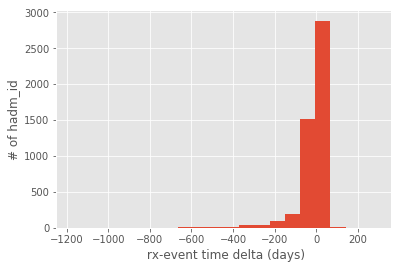

time: 240 ms


In [892]:
imv_intersect2['date delta'].describe()

(imv_intersect2['date delta'] / pd.Timedelta(hours=1)).hist(bins = 20)#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' rx-event time delta (days)')
plt.ylabel('# of hadm_id');

imv_intersect2['date delta'].describe()



In [912]:
from datetime import timedelta

d = timedelta(days=3)

compare_table_gr5= imv_intersect2.loc[abs(imv_intersect2.loc[:,'date delta'])>=d,:]

len(compare_table_gr5)  

# 2073/4830  hadm_id have >=1 day difference. 
# 836/4830 hadm_id have >=2 day difference. 
# 17/4830 hadm_id have >=3 day difference. 
# 5/4830 hadm_id have >=5 day difference.

583

time: 9.16 ms


In [913]:
compare_table_gr5

,subject_id,icustay_id,row_id,event_start_time,endtime,culture_charttime,label,ABrx_start_time,enddate,drug,date delta
20,2298,290252,348482,2105-01-15,2105-01-15 16:01:00,2105-01-14 23:54:00,Ceftriaxone,2105-01-18,2105-01-18,Piperacillin-Tazobactam Na,-3 days
27,2636,296798,1111618,2109-11-02,2109-11-02 00:01:00,2109-11-01 21:29:00,Vancomycin,2109-11-10,2109-11-10,Vancomycin,-8 days
36,3969,211792,44883,2152-06-04,2152-06-04 10:01:00,2152-06-04 08:11:00,Vancomycin,2152-06-07,2152-06-07,Vancomycin,-3 days
52,5897,213466,2252366,2128-01-09,2128-01-09 20:21:00,2128-01-10 19:01:00,Vancomycin,2128-01-16,2128-01-17,Vancomycin,-7 days
60,6700,203317,64653,2137-08-07,2137-08-07 01:46:00,2137-08-07 05:44:00,Piperacillin/Tazobactam (Zosyn),2137-08-13,2137-08-14,Vancomycin,-6 days
73,8427,216108,1797808,2146-09-01,2146-09-01 03:01:00,2146-09-01 05:24:00,Vancomycin,2146-09-10,2146-09-12,CefePIME,-9 days
91,9966,284784,2515867,2167-07-03,2167-07-03 01:48:00,2167-07-02 21:43:00,Ceftriaxone,2167-07-12,2167-07-13,Vancomycin,-9 days
95,10302,276105,56913,2151-07-18,2151-07-18 00:01:00,2151-07-17 23:00:00,Vancomycin,2151-07-21,2151-07-22,Vancomycin,-3 days
101,10675,250919,2110522,2114-11-09,2114-11-09 20:31:00,2114-11-09 09:27:00,Vancomycin,2114-11-15,2114-11-16,Meropenem,-6 days
103,10721,260189,2453759,2192-04-13,2192-04-13 10:42:00,2192-04-13 16:26:00,Vancomycin,2192-04-16,2192-04-20,Vancomycin,-3 days


time: 42.7 ms


In [842]:
# 6) need to count consecutive ab for each pt n=~8174 
#imv_16s_absc24_pt_df.loc[imv_16s_absc24_pt_df.loc[:,'subject_id']==93321,['subject_id','row_id','starttime','endtime','culture_charttime','first_ab_within24hr','label']]

imv_16s_absc24_pt_df

,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,...,chartdate,culture_charttime,spec_itemid,spec_type_desc,sterile_dur_icu,culture_hadm_date_rng,first_sterile_date,culture_count,ab_culture_delta,first_ab_within24hr
1807925,1536790,36,165660,241249,2134-05-13 11:47:00,2134-05-13 11:48:00,225879,1.0000,dose,None,...,2134-05-14,2134-05-14 11:38:00,70012,BLOOD CULTURE,True,0 days 00:00:00,2134-05-14 11:38:00,2,-1 days +00:09:00,2134-05-13 11:47:00
3638799,3493304,85,112077,291697,2167-07-26 00:00:00,2167-07-26 00:01:00,225851,1.0000,dose,None,...,2167-07-25,2167-07-25 17:30:00,70012,BLOOD CULTURE,False,2 days 19:13:00,2167-07-25 16:50:00,4,06:30:00,2167-07-26 00:00:00
72809,43673,109,147469,253139,2141-06-12 18:00:00,2141-06-12 18:01:00,225859,1.0000,dose,None,...,2141-06-13,2141-06-13 03:07:00,70079,URINE,True,0 days 00:00:00,2141-06-13 03:07:00,1,-1 days +14:53:00,2141-06-12 18:00:00
557024,374654,124,138376,256064,2166-01-13 10:00:00,2166-01-13 10:01:00,225884,1.0000,dose,None,...,2166-01-13,2166-01-13 22:31:00,70079,URINE,True,25 days 00:28:00,2166-01-02 08:59:00,14,-1 days +11:29:00,2166-01-13 10:00:00
3635849,3563064,165,170252,247247,2170-10-04 09:30:00,2170-10-04 09:31:00,225845,1.0000,dose,None,...,2170-10-03,2170-10-03 17:40:00,70081,URINE,True,0 days 06:20:00,2170-10-03 11:20:00,3,15:50:00,2170-10-04 09:30:00
1309639,1068463,188,192557,297851,2160-11-26 10:00:00,2160-11-26 10:01:00,225899,1.0000,dose,None,...,2160-11-26,2160-11-26 03:16:00,70012,BLOOD CULTURE,True,0 days 03:16:00,2160-11-26 00:00:00,3,06:44:00,2160-11-26 10:00:00
740315,558883,199,125590,235675,2174-04-12 20:11:00,2174-04-12 20:12:00,225798,1.0000,dose,None,...,2174-04-12,2174-04-12 15:59:00,70079,URINE,True,4 days 04:37:00,2174-04-08 11:22:00,2,04:12:00,2174-04-12 20:11:00
753767,583454,222,103002,256144,2143-02-17 07:21:00,2143-02-17 07:22:00,225879,1.0000,dose,None,...,2143-02-16,2143-02-16 20:23:00,70079,URINE,True,0 days 05:22:00,2143-02-16 15:01:00,3,10:58:00,2143-02-17 07:21:00
2661701,2431937,249,158975,282599,2156-05-01 21:30:00,2156-05-01 21:31:00,225798,1.0000,dose,None,...,2156-05-01,2156-05-01 20:05:00,70012,BLOOD CULTURE,True,10 days 17:11:00,2156-05-01 19:06:00,6,01:25:00,2156-05-01 21:30:00
1259452,1008539,305,194340,217232,2129-09-03 16:05:00,2129-09-03 16:06:00,225851,1.0000,dose,None,...,2129-09-02,2129-09-02 23:03:00,70079,URINE,False,17 days 13:55:00,2129-08-20 20:05:00,16,17:02:00,2129-09-03 16:05:00


time: 75.6 ms


In [841]:
#mv_16_sterile_df.loc[mv_16_sterile_df.loc[:,'subject_id']==36,:]
#inputevents_mv_df.loc[inputevents_mv_df.loc[:,'subject_id']==36,:]

#test_df=inputevents_mv_df

inputevents_mv_df.loc[(inputevents_mv_df.subject_id ==93321) & (inputevents_mv_df.label == 'Cefepime')] #& (inputevents_mv_df.starttime >= '2128-03-25 08:10:00')].sort_values('starttime')
#inputevents_mv_df.loc[(inputevents_mv_df.culture_count > 50)].sort_values('starttime')




#& ('starttime')>= '2134-05-13 11:47:00' 


,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,...,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date,originalamount,originalrate,label
183222,3226197,93321,115396,210628.0,2128-03-25 16:03:00,2128-03-25 16:04:00,225851,1.0,dose,None,...,0,0,0,FinishedRunning,None,None,NaT,1.0,1.0,Cefepime
183372,3226151,93321,115396,210628.0,2128-03-25 08:10:00,2128-03-25 08:11:00,225851,1.0,dose,None,...,0,0,0,FinishedRunning,None,None,NaT,1.0,1.0,Cefepime
183374,3226165,93321,115396,210628.0,2128-03-26 07:45:00,2128-03-26 07:46:00,225851,1.0,dose,None,...,0,0,0,FinishedRunning,None,None,NaT,1.0,1.0,Cefepime
183520,3226190,93321,115396,210628.0,2128-03-26 01:00:00,2128-03-26 01:01:00,225851,1.0,dose,None,...,0,0,0,FinishedRunning,None,None,NaT,1.0,1.0,Cefepime


time: 37.9 ms


In [837]:
#test_df=inputevents_mv_df

ABrx_16sterile_ntnul.loc[(ABrx_16sterile_ntnul.subject_id== 93321) & (ABrx_16sterile_ntnul.drug == 'CefePIME')]
                         #& (inputevents_mv_df.starttime >= '2134-05-13 11:47:00')]

#ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'subject_id']==85,:]
#ABrx_16sterile_ntnul

#why is pt 85 not in ABrx_16sterile_ntnul??????

#24915


,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,...,last_wardid,chartdate,culture_charttime,spec_itemid,spec_type_desc,sterile_dur_icu,culture_hadm_date_rng,first_sterile_date,culture_count,pt_ab_db
72034,4079882,93321,115396,210628,2128-03-25,2128-03-26,MAIN,CefePIME,NaN,NaN,...,52,2128-08-07,2128-08-07 20:59:00,70012,BLOOD CULTURE,False,205 days 07:49:00,2128-03-24 22:45:00,124,mv_ab
72035,4079883,93321,115396,210628,2128-03-25,2128-05-19,MAIN,CefePIME,NaN,NaN,...,52,2128-08-07,2128-08-07 20:59:00,70012,BLOOD CULTURE,False,205 days 07:49:00,2128-03-24 22:45:00,124,mv_ab


time: 34.2 ms


# compiling the dataframes into csv's

In [1591]:
date='04-26-18'


pd.DataFrame(final_events_df).to_csv("final_events_df_%s.csv" %date)
pd.DataFrame(ABrx_16sterile_ntnul).to_csv('ABrx_16sterile_ntnul_%s.csv' %date) #all prescription table rows and pts.
pd.DataFrame(final_pts_all_sc).to_csv('final_pts_all_sc_%s.csv' %date) #all sterile culture, and hospital/icu info
#pd.DataFrame(ABrx_16sterile_ntnul).to_csv('ABrx_16sterile_ntnul_%s.csv' %date)
pd.DataFrame(ptinfo_ICUsterile_16).to_csv('ptinfo_ICUsterile_16_%s.csv' %date)
pd.DataFrame(ptinfo_ICUsterile_16_pt).to_csv('ptinfo_ICUsterile_pt_16_%s.csv' %date)
#pd.DataFrame(ABrx_16sterile_ntnul_pts).to_csv('ABrx_16sterile_ntnul_pts_%s.csv' %date)


time: 28.1 s


In [1590]:
date='04-26-18'

pd.DataFrame(final_events_df).to_csv("final_events_df_%s.csv" %date)

time: 4.43 s


# unused code

In [439]:
# Inputs: FINAL_PT_LIST, FINAL_DITEM_ABLIST
# Output: final_events_df #   

final_events_sql = query_schema + """
SELECT a.row_id, a.subject_id, a.charttime, a.itemid, a.icustay_id, a.hadm_id, a.storetime, cv.cgid, cv.value, cv.valuenum, mv.endtime, mv.statusdescription, mv.cancelreason, mv.ordercategorydescription, mv.linkorderid, di.label
FROM (SELECT cv.row_id, cv.subject_id, cv.charttime, cv.itemid, cv.icustay_id, cv.hadm_id, cv.storetime
    FROM mimiciii.chartevents cv
    WHERE cv.subject_id in {} and cv.itemid in {}
    UNION
    SELECT mv.row_id, mv.subject_id, mv.starttime, mv.itemid, mv.icustay_id, mv.hadm_id, mv.storetime
    FROM mimiciii.inputevents_mv mv
    WHERE mv.subject_id in {} and mv.itemid in {}
) AS a
left join (SELECT cv.row_id, cv.subject_id, cv.cgid, cv.value, cv.valuenum FROM mimiciii.chartevents cv WHERE cv.subject_id in {} and cv.itemid in {}) cv on a.row_id= cv.row_id
left join (SELECT mv.row_id, mv.subject_id, mv.endtime, mv.statusdescription, mv.cancelreason, mv.ordercategorydescription, mv.linkorderid FROM mimiciii.inputevents_mv mv WHERE mv.subject_id in {} and mv.itemid in {}) mv on a.row_id= mv.row_id
left join (SELECT itemid, label from mimiciii.d_items di WHERE itemid in {}) di on a.itemid= di.itemid


ORDER BY a.subject_id, a.charttime ASC

""".format(tuple(FINAL_PT_LIST),tuple(FINAL_DITEM_ABLIST),tuple(FINAL_PT_LIST),tuple(FINAL_DITEM_ABLIST),tuple(FINAL_PT_LIST),tuple(FINAL_DITEM_ABLIST),tuple(FINAL_PT_LIST),tuple(FINAL_DITEM_ABLIST),tuple(FINAL_DITEM_ABLIST))

final_events_df =pd.read_sql_query(final_events_sql,conn) 


# # FINAL_DITEM_ABLIST=FINAL_DITEM_ABLIST #final ab ditem list
# # FINAL_PT_LIST= cvmv_16sterile_list #final patient list
# # FINAL_PT_LIST= list(FINAL_DITEM_ABLIST['subject_id'].unique()) #final patient list

# # ###### includes my and kishore's ab list (mine based on reg expression and rule based parsing
# # of the ATC + microbio ab names. i then iterated with every ab name with sql like statement in d_items
# # to get all item id's. )


# #final_events_df = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/final_events_df_04-16-18.csv', index_col=0)

# #15 min runtime ><



time: 14min 56s


In [ ]:
# ####we should only use invputevents_mv, all rows except 105 in chartevents are lab measurements, not ab doses.

# final_events_df['source']=""
# final_events_df['exclude']=""
# #mv.linkorderid
# final_events_df.loc[final_events_df.loc[:,'statusdescription'].notnull(),'source'] = 'inputevents_mv'
# final_events_df.loc[final_events_df.loc[:,'linkorderid'].notnull(),'source'] = 'inputevents_mv'
# final_events_df.loc[final_events_df.loc[:,'value'].notnull(),'source'] = 'chartevents'
# #len(final_events_df[final_events_df['value'].notnull()])

# #following item id are ab measurements: 
# abmeasurement_list=[855, 856, 854, 846, 845, 847]
# abmeasurement_list2=['Vancomycin (Trough)','Vancomycin (Random)','Gentamicin (Trough)','Gentamicin (Random)',
# 'Tobramycin (Random)','Tobramycin (Trough)','Gentamicin (Peak) ','Tobramycin (Peak)','Vancomycin (Peak)','Gentamicin (Peak)']


# final_events_df.loc[final_events_df.loc[:,'label'].isin(abmeasurement_list2),'exclude']= 'exclude' 
# final_events_df.loc[final_events_df.loc[:,'itemid'].isin(abmeasurement_list),'exclude']= 'exclude' 

   
# final_events_df.loc[(final_events_df.exclude!='exclude')&(final_events_df.source=='chartevents')] #n=105.

In [ ]:
#if the below doesn't work, i can will need to merge them in python. 

# compare_table=0
# compare_table = pd.DataFrame({
#     'row_id': [],
#     'subject_id': [],
#     'charttime': [],
#     'itemid': [],
#     'icustay_id': [],
#     'hadm_id': [],
#     'value': [],
#     'valuenum': [],
#     'endtime': [],
#     'statusdescription': [],
#     'cancelreason': [],
#     'ordercategorydescription': [],
#     'cancelreason': [],
#     'ordercategorydescription': [],
#     'linkorderid': [],
#     'label': [],
# }, columns=[    
#     'row_id',
#     'subject_id',
#     'charttime',
#     'itemid',
#     'icustay_id',
#     'hadm_id',
#     'value',
#     'valuenum',
#     'endtime',
#     'statusdescription',
#     'cancelreason',
#     'ordercategorydescription',
#     'cancelreason',
#     'ordercategorydescription',
#     'linkorderid',
#     'label'])





In [441]:
# print(len(final_events_df),
# len(final_events_df['subject_id'].unique()))

208007 10753
time: 3.99 ms


In [ ]:
# import seaborn as sns
# ditems_sql = query_schema + """
# select * from mimiciii.d_items
# """
# ditems=pd.read_sql_query(ditems_sql,conn)


# ditems_abxid=pd.DataFrame(FINAL_DITEM_ABLIST)
# #FINAL_DITEM_ABLIST

# subset_ditems=ditems.loc[ditems['itemid'].isin(FINAL_DITEM_ABLIST)]

issue to resolve:
    
    Although there are more antibiotic item id's linked to CV, we recruited more AB patients from MV. 
    
    we may have duplicated ab info for patients in both databases

In [ ]:
# # number of antibiotic item id's based on source table
# print(t)
# sns.countplot(y="linksto", data=subset_ditems)

In [649]:
# # number of antibiotic item id's based on source table
# sns.countplot(y="dbsource", data=subset_ditems)
# print(t)

NameError: name 'subset_ditems' is not defined

time: 249 ms


In [ ]:
# #last minute qc before presentation... sigh...
# #final_events_df['subject_id'].value_counts().plot.hist(70, xlab='pt')
# final_events_df['subject_id'].value_counts().plot.hist(70)
# #sns.countplot(y="subject_id", data=final_events_df)

In [ ]:
# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# final_events_df.subject_id.value_counts().head(20).sort_values(ascending=True).plot.bar()

In [ ]:
# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# sns.regplot(x="icu_length_of_stay", y="subject_id", data=length_of_stay)

In [ ]:
#to add:
#adding the time delta columns on events and rx
#adding a potentially combined list of timepoints. 


In [ ]:
#mv_16_sterile_24hrdelta_df.groupby('subject_id').agg({'starttime': lambda x: min(x)}).get_group(('starttime', 'row_id'))
# mv_16_sterile_24hrdelta_df.groupby('subject_id')#.agg({'starttime': lambda x: min(x)}).get_group(('starttime', 'row_id'))



# ok so i have every row where ab is within +/-24 hours of sterile culture.
# i now need to select the lowest ab date for each patient/icustay.id. i then need a way to select just htese rows.



#mv_16_sterile_24hrdelta_df.groupby('icustay_id').transform(lambda x: x['starttime']==min(x['starttime']))

#dff.groupby('B').filter(lambda x: len(x['C']) > 2)
                                                      
#                                                       #: min(x), ''})
# ['starttime'].transform(lambda x: min(x))


# grouped.agg({'C' : np.sum,'D' : lambda x: np.std(x, ddof=1)})

In [ ]:
style guide stuff:
    
79 characters is longest a line should be, this is 79 chars:
Address the unique rows issue in the sterile culture. Need to use this to filkter down the staph.